In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coffee-bean-tanvir/Coffee Bean.csv
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (2).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (95).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (45).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (8).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (83).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (15).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (98).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (91).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (22).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (23).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (75).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (55).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (11).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (39).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (100).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (33).png
/kaggle/input/coffee-bean-tanvir/test/Da

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
import matplotlib.pyplot as plt

2025-08-27 09:36:29.898195: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756287390.094101      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756287390.156777      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
base_dir = "/kaggle/input/coffee-bean-tanvir"

def create_dataframe(data_dir):
    file_paths = []
    labels = []

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            file_paths.append(image_path)
            labels.append(class_name)

    df = pd.DataFrame({"file_path": file_paths, "label": labels})
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_df = create_dataframe(os.path.join(base_dir, "train"))
test_df = create_dataframe(os.path.join(base_dir, "test"))

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (1200, 2)
Test shape: (400, 2)


In [4]:
# ----- Cell 3: Data Augmentation and Generators -----
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Validation/Test data only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse'   # 'sparse' for integer labels
)

# Test/Validation generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False  # important for evaluation
)

# Get number of classes
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

Found 1200 validated image filenames belonging to 4 classes.
Found 400 validated image filenames belonging to 4 classes.
Number of classes: 4


In [5]:
def se_block(input_tensor, ratio=16):
    channel = input_tensor.shape[-1]
    
    # Squeeze
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1,1,channel))(se)
    
    # Excitation
    se = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal')(se)
    se = layers.Dense(channel, activation='sigmoid', kernel_initializer='he_normal')(se)
    
    # Scale
    x = layers.Multiply()([input_tensor, se])
    return x

In [6]:
def build_se_cnn(input_shape=(128,128,3), num_classes=4):
    inputs = Input(shape=input_shape)

    # Conv Block 1
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)

    # Conv Block 2
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)

    # Conv Block 3
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = se_block(x)

    # Flatten + Dense
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_se_cnn(num_classes=num_classes)
model.summary()

I0000 00:00:1756287403.928816      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 2)   │         66 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 32)  │         96 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ multiply[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_1[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1, 4)   │        260 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 1, 64)  │        320 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│ (Multiply)          │ 64)               │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ multiply_1[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ max_pooling2d_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 128) │          0 │ global_average_p

 Total params: 8,486,066 (32.37 MB)

 Trainable params: 8,486,066 (32.37 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1756287410.765630      60 service.cc:148] XLA service 0x7dab5c009e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756287410.766270      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756287411.369962      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/38 ━━━━━━━━━━━━━━━━━━━━ 5:41 9s/step - accuracy: 0.1875 - loss: 1.3898

I0000 00:00:1756287415.136351      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 455ms/step - accuracy: 0.3198 - loss: 1.3471 - val_accuracy: 0.6950 - val_loss: 0.7030
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.8163 - loss: 0.5003 - val_accuracy: 0.9225 - val_loss: 0.1982
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.9408 - loss: 0.1688 - val_accuracy: 0.9150 - val_loss: 0.2127
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.9443 - loss: 0.1392 - val_accuracy: 0.9700 - val_loss: 0.1021
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.9660 - loss: 0.0960 - val_accuracy: 0.8625 - val_loss: 0.3054
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.9394 - loss: 0.1628 - val_accuracy: 0.9675 - val_loss: 0.0901
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.9731 - loss: 0.0926 - val_accuracy: 0.9800 - val_loss: 0.0747
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.9635 - loss: 0.0994 - val_accuracy: 0.9375 - val

In [8]:
# Remove last dense layer
feature_extractor = models.Model(inputs=model.input, outputs=model.layers[-3].output)  # last Flatten layer before Dense

# Extract features
def extract_features(generator, feature_model):
    features = feature_model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

X_train_features, y_train_labels = extract_features(train_generator, feature_extractor)
X_test_features, y_test_labels = extract_features(test_generator, feature_extractor)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


In [9]:
# Initialize and train an SVC
svm_model = SVC(probability=True, random_state=42) # probability=True to get probabilities for ROC curve
svm_model.fit(X_train_scaled, y_train_labels)

SVC(probability=True, random_state=42)

Accuracy: 0.0275
Precision: 0.0651645127748069
Recall: 0.0275
F1-score: 0.035444724824820806
Confusion Matrix:
 [[ 7 65 16 12]
 [28  1  0 71]
 [16 22  2 60]
 [ 0 99  0  1]]


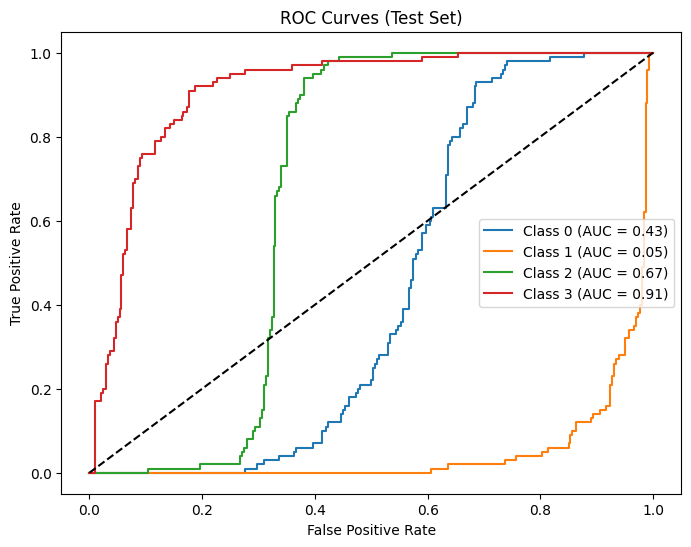

Test AUC: 0.5151166666666667


In [10]:
# ----- Cell 8: Evaluate SVC -----
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# ---- Predictions ----
y_test_pred = svm_model.predict(X_test_scaled)
y_test_proba = svm_model.predict_proba(X_test_scaled)

# ---- Basic Metrics ----
print("Accuracy:", accuracy_score(y_test_labels, y_test_pred))
print("Precision:", precision_score(y_test_labels, y_test_pred, average='macro'))
print("Recall:", recall_score(y_test_labels, y_test_pred, average='macro'))
print("F1-score:", f1_score(y_test_labels, y_test_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_test_pred))

# ---- ROC-AUC Curves ----
# Binarize labels for multi-class ROC
classes_present = np.unique(y_test_labels)
y_test_bin = label_binarize(y_test_labels, classes=classes_present)

# Only plot ROC if at least 2 classes are present
if y_test_bin.shape[1] > 1:
    plt.figure(figsize=(8,6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {classes_present[i]} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test Set)")
    plt.legend()
    plt.show()

    # Compute overall ROC-AUC
    print("Test AUC:", roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr'))
else:
    print("ROC-AUC skipped: less than 2 classes present in test set")